In [211]:
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import missingno as msno

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Exploratory Data Analysis

The data were provided by Mia Lieberman (DCM), for her project on testing the efficacy of a variety of smartphone sanitization methods.

In [212]:
data = pd.read_csv('smartphone_sanitization_manuscript.csv', na_values=['#DIV/0!'])

Let's take a quick look at her data matrix.

In [213]:
data.head()

,sample_id,treatment,colonies_pre,colonies_post,perc_reduction colonies,morphologies_pre,morphologies_post,year,month,day,perc_reduction morph,site,phone ID,no case,screen protector
0,1,phonesoap,0,0,NaN,0,0,2015.0,10.0,7.0,NaN,phone,4,NaN,NaN
1,2,phonesoap,12,0,100.000000,3,0,2015.0,10.0,7.0,100.0,junction,4,NaN,NaN
2,3,phonesoap,14,4,71.428571,5,2,2015.0,10.0,7.0,60.0,case,4,NaN,NaN
3,4,ethanol,0,0,NaN,0,0,2016.0,4.0,20.0,NaN,phone,4,NaN,NaN
4,5,ethanol,0,1,NaN,0,1,2016.0,4.0,20.0,NaN,junction,4,NaN,NaN


In [214]:
data.columns

Index(['sample_id', 'treatment', 'colonies_pre', 'colonies_post',
       'perc_reduction colonies', 'morphologies_pre', 'morphologies_post',
       'year', 'month', 'day', 'perc_reduction morph', 'site', 'phone ID',
       'no case', 'screen protector'],
      dtype='object')

It's apparent that Mia is an excellent data curator! It's a flat file, with each row being one observation, and the raw data, derivative data, and metadata are all stored.

Before we continue on analyzing the data, let's quickly check the data for completeness.

/Users/ericmjl/anaconda/lib/python3.5/site-packages/missingno/missingno.py:250: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  ax1.set_axis_bgcolor((1, 1, 1))


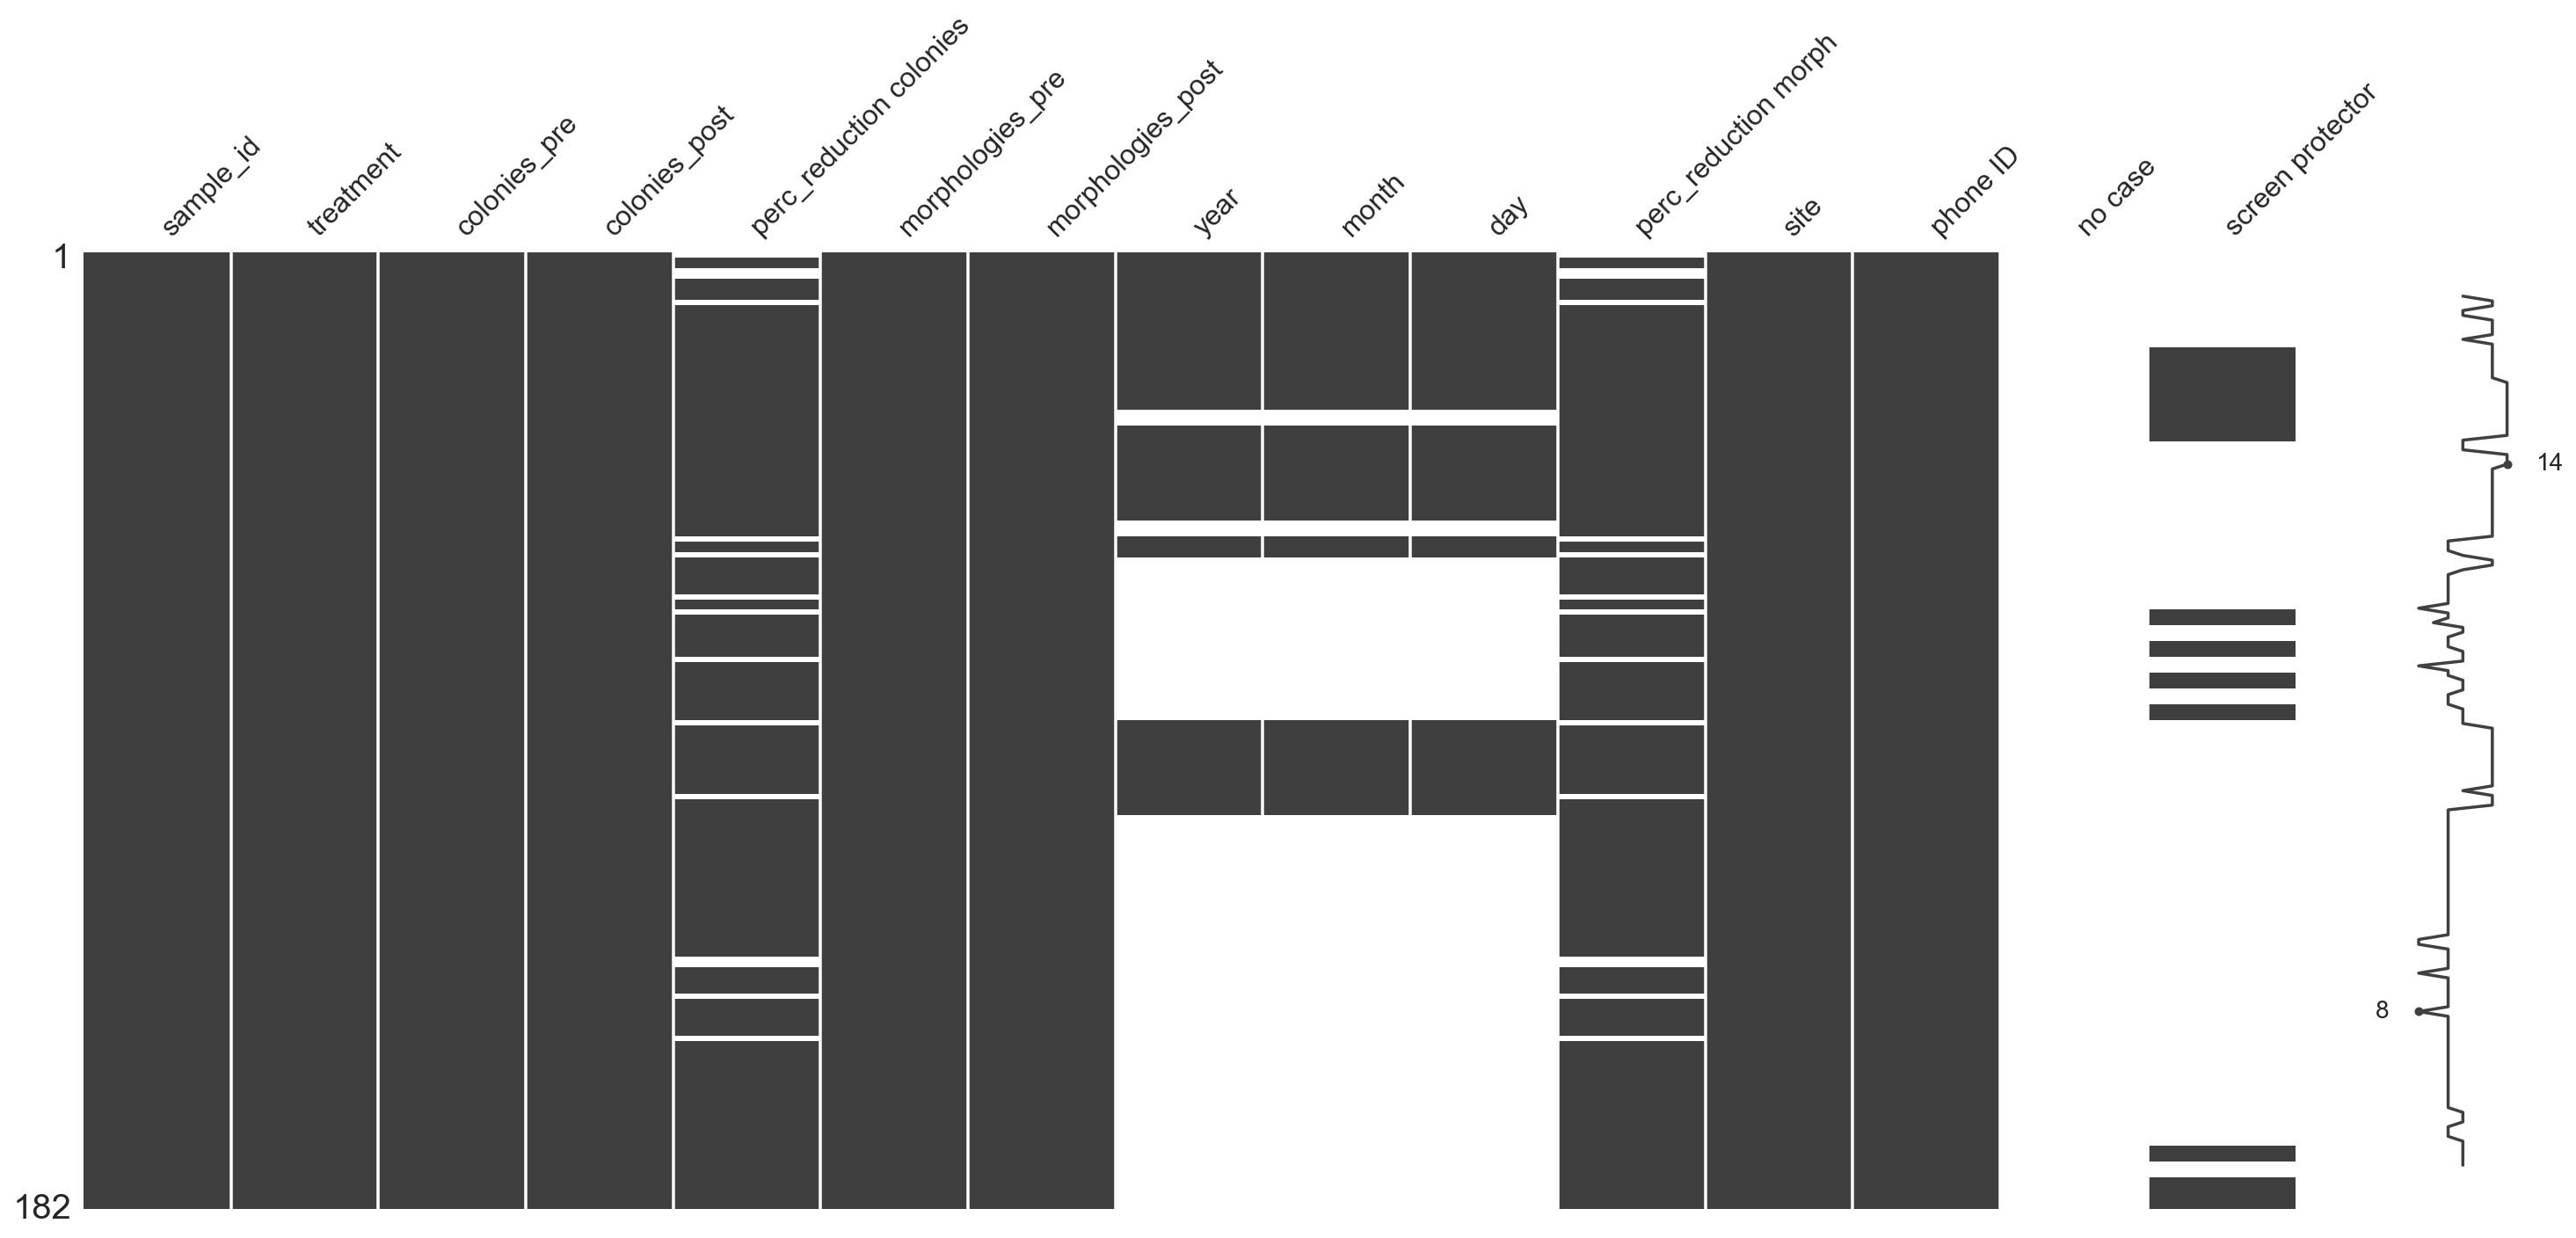

In [215]:
msno.matrix(data)

It's clear here that not every row of data has the year/month/day information recorded. On the other hand, the columns that I expect to have complete data (`colonies_pre`, `colonies_post`, `morphologies_pre`, `morphologies_post`) are all present.

Just to get a feel for her data, let's look at the mean pre- and post-treatment CFU for each treatment method, and see if it matches what she has in her slides.

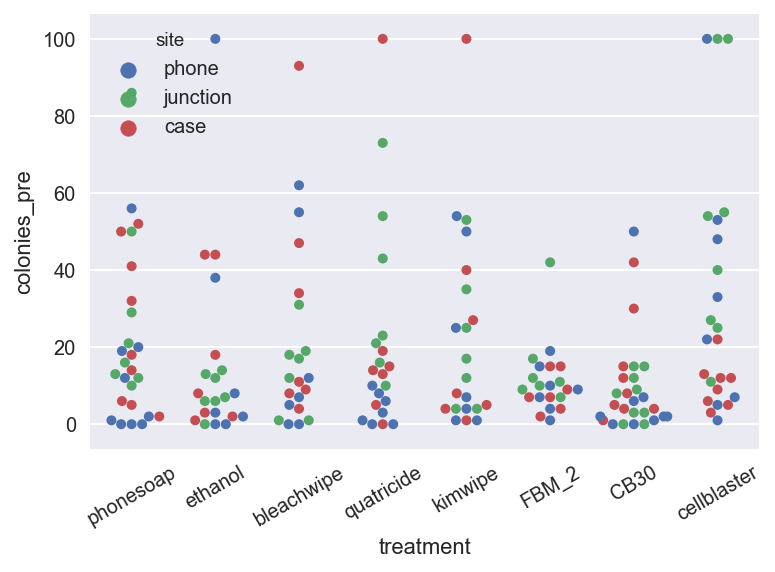

In [239]:
# data.groupby('treatment').mean().plot(kind='bar', y=['colonies_pre', 'colonies_post'], yerr=data.groupby('treatment').std())
fig = sns.swarmplot(data=data, x='treatment', y='colonies_pre', hue='site')
plt.xticks(rotation=30)
plt.show()

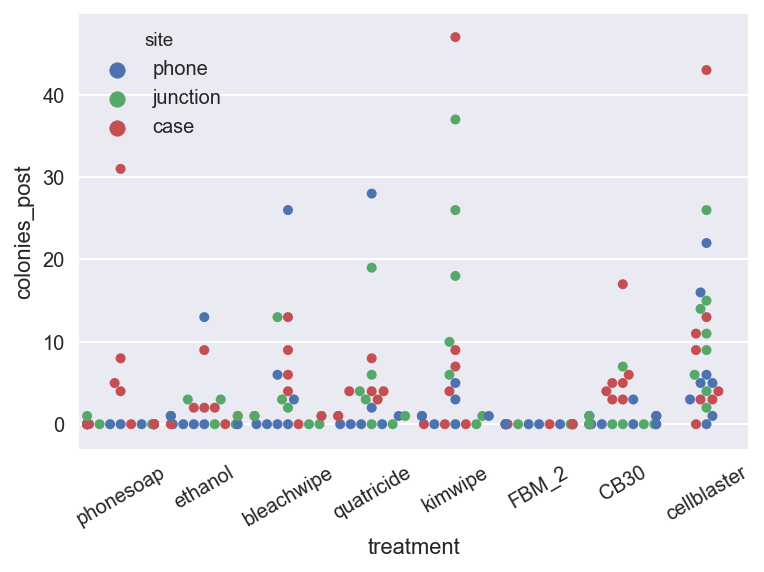

In [240]:
fig = sns.swarmplot(data=data, x='treatment', y='colonies_post', hue='site')
plt.xticks(rotation=30)
plt.show()

Indeed it does; good sanity check.

Mia's data involves a number of rows where zeroes are divided by other zeroes in order to compute the percentage reduction in colonies. I think there might be a more principled way to go about this, so that we don't have to end up ignoring the data where no colonies were found (because of division by zero).

Colonies are discrete count data. We can probably use a Poisson likelihood for `colonies_pre` and `colonies_post` in a Bayesian framework, and then use that to estimate the reduction percentage with uncertainty. In doing so, there's no need to worry about p-values and the likes.

In [241]:
from sklearn.preprocessing import LabelEncoder

In [242]:
# Reload the data one more time.
data = pd.read_csv('smartphone_sanitization_manuscript.csv', na_values=['#DIV/0!'])
del data['perc_reduction colonies']
data['perc_change_colonies'] = (data['colonies_post'] - data['colonies_pre']) / data['colonies_pre']
data.head()

,sample_id,treatment,colonies_pre,colonies_post,morphologies_pre,morphologies_post,year,month,day,perc_reduction morph,site,phone ID,no case,screen protector,perc_change_colonies
0,1,phonesoap,0,0,0,0,2015.0,10.0,7.0,NaN,phone,4,NaN,NaN,NaN
1,2,phonesoap,12,0,3,0,2015.0,10.0,7.0,100.0,junction,4,NaN,NaN,-1.000000
2,3,phonesoap,14,4,5,2,2015.0,10.0,7.0,60.0,case,4,NaN,NaN,-0.714286
3,4,ethanol,0,0,0,0,2016.0,4.0,20.0,NaN,phone,4,NaN,NaN,NaN
4,5,ethanol,0,1,0,1,2016.0,4.0,20.0,NaN,junction,4,NaN,NaN,inf


In [243]:
# Encode the treatment indices.
le = LabelEncoder()
data['treatment_idx'] = le.fit_transform(data['treatment'])

Because we are modelling the count data using a Poisson distribution, we need a non-informative prior to be placed on the Poisson rate parameter $\mu_{pre}$ and $\mu_{post}$. We will use the Discrete Uniform prior, with a wide range from 0 to 1000, for each of the pre- and post-treatment colony counts.

Finally, to compute the fractional change, we will take the pre- and post-counts posterior distributions and divide them according to the formula:

$$ \delta_{p} = \frac{\mu_{post} - \mu_{pre}}{\mu_{pre}}$$

Here, $ \delta_{p} $ is the fractional change. Negative values indicate reduction, positive values indicate increases.

In [220]:
with pm.Model() as model:
    mu_pre = pm.DiscreteUniform('pre_mus', lower=0, upper=1000, shape=len(le.classes_))
    pre_mus = mu_pre[data['treatment_idx']]
    pre_counts = pm.Poisson('pre_counts', mu=pre_mus, observed=data['colonies_pre'])
    
    mu_post = pm.DiscreteUniform('post_mus', lower=0, upper=1000, shape=len(le.classes_))
    post_mus = mu_post[data['treatment_idx']]
    post_counts = pm.Poisson('post_counts', mu=post_mus, observed=data['colonies_post'])

    perc_change = pm.Deterministic('perc_change', (mu_post - mu_pre) / mu_pre)

In [221]:
# Sample 10000 steps in the MCMC chain.
with model:
    trace = pm.sample(10000)

Assigned Metropolis to pre_mus
Assigned Metropolis to post_mus
100%|██████████| 10000/10000 [00:02<00:00, 3473.20it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13fa152e8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x14016a2e8>]], dtype=object)

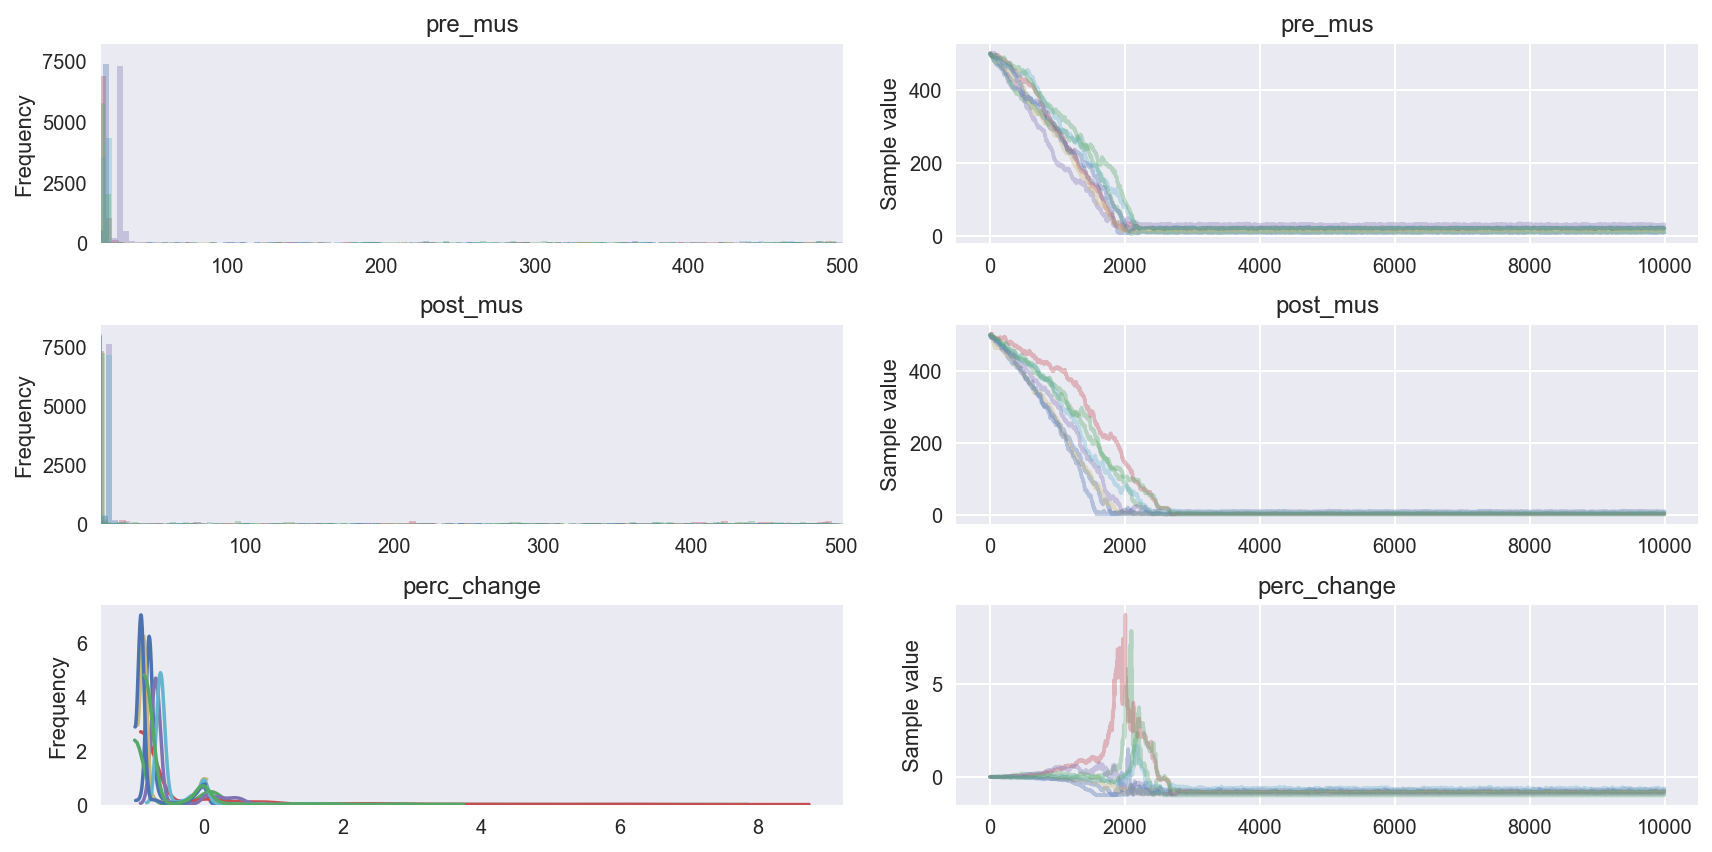

In [244]:
pm.traceplot(trace)

Looking at the trace plots, it's quite clear that convergence with MCMC is reached only after ~2500 steps. To be conservative, we will use only traces from step 3000 onwards.

In [245]:
cutoff = 3000

Let's now plot the posterior estimates of the pre-treatment $\mu_{pre}$ and post-treatment $\mu_{post}$ colony counts, and percentage reduction in colony counts $\delta_{p}$.

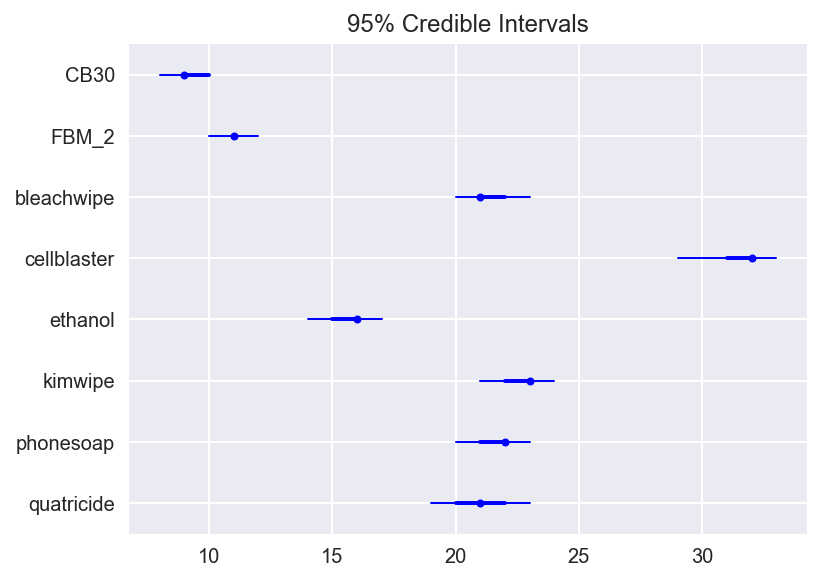

In [248]:
# Plot pre-treatment
pm.forestplot(trace[cutoff:], varnames=['pre_mus'], ylabels=le.classes_)

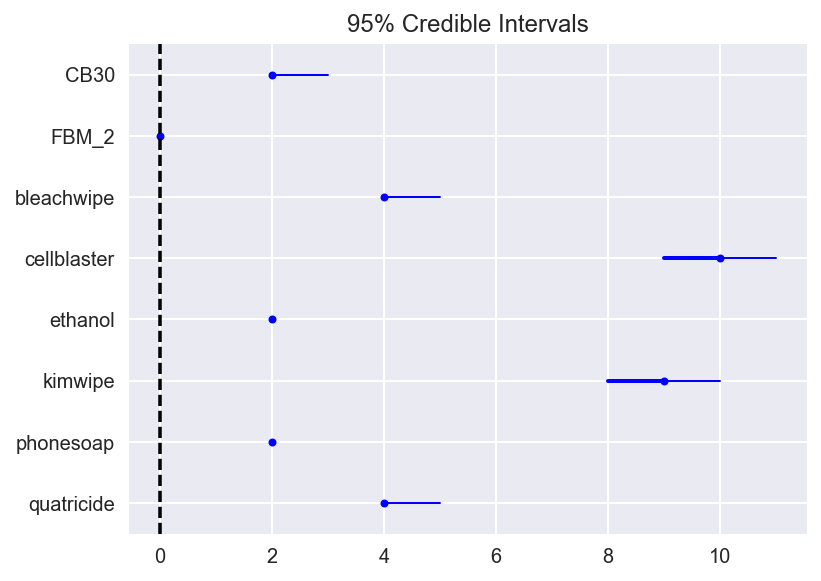

In [249]:
# Plot post-treatment
pm.forestplot(trace[cutoff:], varnames=['post_mus'], ylabels=le.classes_)

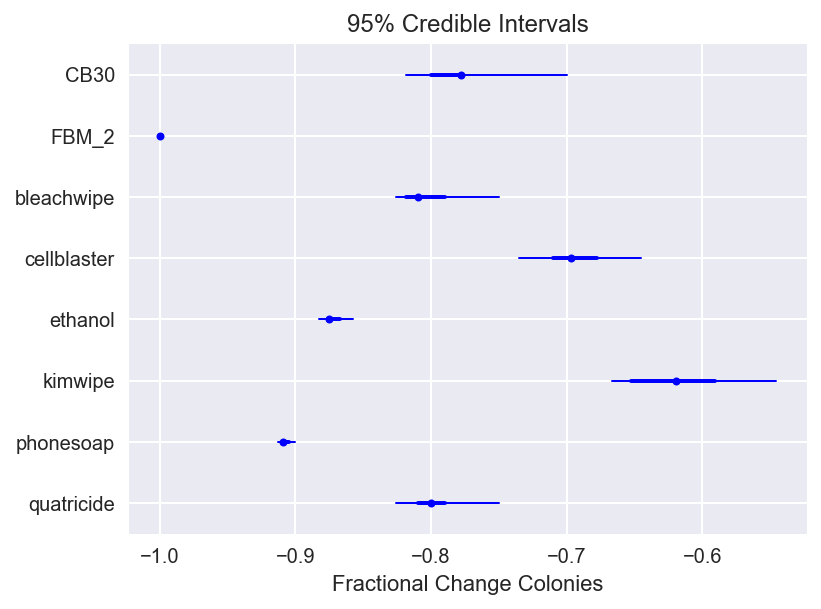

In [253]:
# Plot percentage reduction
pm.forestplot(trace[cutoff:], varnames=['perc_change'], ylabels=le.classes_, xtitle='Fractional Change Colonies')

From this analysis, it is clear that all of the methods are capable of sterilizing, but FBM_2 gives the most **consistent** sterilization. The posterior densities show the 95% credible intervals for the amount of sterilization, given the data on hand.